#EE673 Project

Team Members: Niraj Kumar, Archit Sood
<br>
Topic: Reinforcement Learning

In [53]:
#@title Install gymnasium and pygame
!pip install gymnasium
!sudo apt install swig
!pip install gymnasium[box2d]
!pip install pygame
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [54]:
SEED = 0

In [55]:
#@title Import
import gymnasium as gym
import pygame
import random
random.seed(SEED)
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40)
import tensorflow as tf
import numpy as np
np.random.seed(SEED)
import random
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import torch
torch.manual_seed(SEED)
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import tqdm

In [56]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

#@title Function for video rendering purpose
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)

Video Rendering Part Reference :
https://cutt.ly/F3JsIa5

"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
  return env

def run_episode(env,agent,print_rew=True):
    s = env.reset()[0]
    rew = 0
    step = 0
    act_dict = {}
    for i in range(5000):
        step += 1
        act = agent.get_greedy_action(s)
        observation, reward, terminated, truncated,_ = env.step(act)
        if act in act_dict.keys():
          act_dict[act] += 1
        else:
          act_dict[act] = 1
        rew += reward
        env.render()
        if terminated == True or truncated == True:
            break
        s = observation
    return rew

def env_render(env,agent,print_rew=True):
    s = env.reset()[0]
    rew = 0
    step = 0
    act_dict = {}
    for i in range(5000):
        step += 1
        act = agent.get_greedy_action(s)
        observation, reward, terminated, truncated = env.step(act)
        if act in act_dict.keys():
          act_dict[act] += 1
        else:
          act_dict[act] = 1
        rew += reward
        env.render()
        if terminated == True or truncated == True:
            break
        s = observation
    if print_rew==True:
      print(f"Reward = {rew}")

In [57]:
class ReplayBuffer:
    def __init__(self, action_size=4, buffer_size=50000, batch_size=60, seed=0):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = seed
        self.buffer_size = buffer_size

    def add(self, state, action, reward, next_state, done):
        self.memory.append({"state":state, "action":action, "reward":reward, "next_state":next_state, "done":done})

    def sample(self):
        sample = random.sample(self.memory, k=self.batch_size)
        return sample

    def __len__(self):
        return len(self.memory)

In [58]:
class QNetwork(nn.Module):
      def __init__(self,input_size=8,output_size=4,seed=0):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_size,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=4),
        )
      def forward(self,X):
        return self.layers(X)

In [59]:
class Deep_Q_Learning:
  def __init__(
      self,
      env,
      *,
      state_size=None,
      action_size=None,
      q_predictor_model=None,
      optimizer = None,
      criterion = None,
      epsilon=0.99, #epsilon will decay during training
      min_epsilon = 0.01,
      epsilon_decay = 0.995,
      param_update_freq=5,
      seed=0,
      device="cpu",
      batch_size = 60,
      buffer_size = 50000,
      lr = 9e-4, #for optimizer(used only if optimizer is None)
      log_freq = 100, #print log every log_freq episodes
      new_method = False
      ):
    self.env = env
    if state_size is not None:
      self.state_size = state_size
    else:
      self.state_size = env.observation_space._shape[0]
    if action_size is not None:
      self.action_size = action_size
    else:
      self.action_size = env.action_space.n

    self.device = device
    self.epsilon = epsilon
    self.min_epsilon = min_epsilon
    self.epsilon_decay = epsilon_decay
    self.param_update_freq = param_update_freq
    self.seed = seed

    self.batch_size = batch_size
    self.buffer_size = buffer_size
    self.log_freq = log_freq
    self.new_method = new_method
    self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)

    if q_predictor_model is not None:
      self.local_model = q_predictor_model()
      self.target_model = q_predictor_model()
    else:
      self.local_model = self._default_model()
      self.target_model = self._default_model()

    if optimizer is None:
      self.optimizer = torch.optim.Adam(self.local_model.parameters(),lr = lr)
    else:
      self.optimizer = optimizer

    if criterion is None:
      self.criterion = F.mse_loss
    else:
      self.criterion = criterion

    # time_stamp for training
    self.total_steps = 0
    self.rewards = [] #To store rewards per episode during training

  def _default_model(self):
    class default_model(nn.Module):
      def __init__(self,state_size,action_size,):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=state_size,out_features=state_size*10),
            nn.ReLU(),
            nn.Linear(in_features=state_size*10,out_features=state_size*10),
            nn.ReLU(),
            nn.Linear(state_size*10,action_size)
        )
      def forward(self,X):
        return self.layers(X)
    return default_model(self.state_size,self.action_size)

  def get_greedy_action(self,s):
    # print(torch.from_numpy(s).unsqueeze(0).shape)
    return self.local_model(torch.from_numpy(s).unsqueeze(0).to(self.device)).argmax().item()

  def get_epsilon_greedy_action(self,s,epsilon=None):
    if epsilon is None:
      epsilon = self.epsilon
    if random.random() > epsilon:
      return self.get_greedy_action(s)
    else:
      return random.choice(np.arange(self.action_size))

  def soft_update(self, p=0.001):
    for target_param, local_param in zip(self.target_model.parameters(),self.local_model.parameters()):
        target_param.data.copy_(p*local_param.data + (1.0-p)*target_param.data)

  def _make_batch(self):
    sample_batch = self.memory.sample()

    states = torch.from_numpy(np.stack([e["state"] for e in sample_batch if e is not None])).float().to(self.device)
    actions = torch.from_numpy(np.stack([e["action"] for e in sample_batch if e is not None])).long().to(self.device).unsqueeze(1)
    rewards = torch.from_numpy(np.stack([e["reward"] for e in sample_batch if e is not None])).float().to(self.device).unsqueeze(1)
    next_states = torch.from_numpy(np.stack([e["next_state"] for e in sample_batch if e is not None])).float().to(self.device)
    dones = torch.from_numpy(np.stack([e["done"] for e in sample_batch if e is not None]).astype(np.uint8)).float().to(self.device).unsqueeze(1)
    return states,actions,rewards,next_states,dones

  def _update_epsilon(self):
    self.epsilon = max(self.epsilon*self.epsilon_decay,0.01)

  def train(self,num_episodes,max_episode_len=1000,gamma=0.99,ep_cnt=0,len_avg_window=50):
    rew_list = deque(maxlen=len_avg_window)
    for e in tqdm(range(ep_cnt+1,num_episodes+ep_cnt+1)):
      rew_eps = 0
      state = self.env.reset()[0]
      for i in range(max_episode_len):
        self.total_steps += 1
        action = self.get_epsilon_greedy_action(state)
        observation, reward, terminated, truncated, info = self.env.step(action)
        # observation, reward, terminated, truncated, info = self.env.step(np.array(int(action)))

        self.memory.add(state, action, reward, observation, terminated)

        rew_eps += reward

        if self.new_method == False:
          state = observation

        if self.total_steps%self.param_update_freq != 0 or len(self.memory) < self.batch_size:
          continue


        if self.new_method == True:
          state = observation

        states,actions,rewards,next_states,dones = self._make_batch()
        # print(states.shape,actions.shape,rewards.shape,next_states.shape,dones.shape)

        val_batch = self.local_model(states)
        next_val_batch = self.target_model(next_states)
        q_target = rewards + (0.99*(next_val_batch).max(dim=1).values).unsqueeze(1)*(1-dones)
        q_val_obtained = val_batch.gather(1,actions)

        loss = self.criterion(q_val_obtained,q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update()


        if terminated == True or truncated == True:
          self._update_epsilon()
          break

      rew_list.append(rew_eps)
      self.rewards.append(rew_eps)
      print("\r",f"episode no: {e} reward(avg prev {len_avg_window} eps): {np.mean(rew_list):.2f}",end="")
      if e%self.log_freq==0:
        print("\r",f"episode no: {e} reward(avg prev {len_avg_window} eps): {np.mean(rew_list):.2f}")

##LunarLander Environment

In [60]:
env = gym.make("LunarLander-v2",render_mode=None)
agent = Deep_Q_Learning(env,new_method=False)
agent.train(600)

  0%|          | 0/600 [00:00<?, ?it/s]

 episode no: 100 reward(avg prev 50 eps): -406.99
 episode no: 200 reward(avg prev 50 eps): -359.62
 episode no: 300 reward(avg prev 50 eps): -309.20
 episode no: 400 reward(avg prev 50 eps): -68.21
 episode no: 500 reward(avg prev 50 eps): -45.46
 episode no: 600 reward(avg prev 50 eps): -36.88


In [61]:
env = gym.make("LunarLander-v2",render_mode=None)
agent_new = Deep_Q_Learning(env,new_method=True)
agent_new.train(600)

  0%|          | 0/600 [00:00<?, ?it/s]

 episode no: 100 reward(avg prev 50 eps): -415.52
 episode no: 200 reward(avg prev 50 eps): -289.60
 episode no: 300 reward(avg prev 50 eps): -245.05
 episode no: 400 reward(avg prev 50 eps): 155.20
 episode no: 500 reward(avg prev 50 eps): 365.51
 episode no: 600 reward(avg prev 50 eps): 330.44


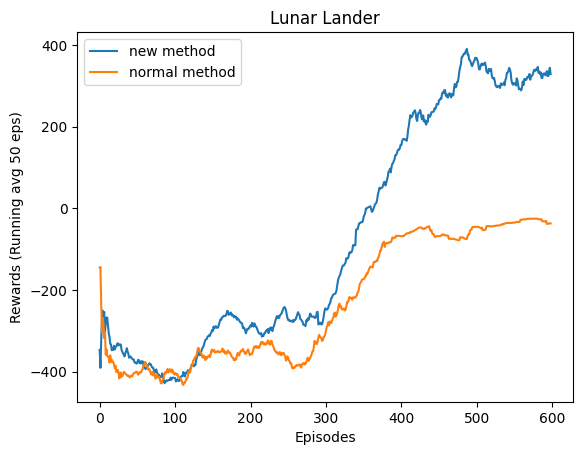

In [62]:
running_avg_len = 50
plt.title("Lunar Lander")
plt.xlabel("Episodes")
plt.ylabel(f"Rewards (Running avg {running_avg_len} eps)")
plt.plot([np.mean(agent_new.rewards[max(0,i-running_avg_len):i]) for i in np.arange(1,len(agent_new.rewards))],label="new method")
plt.plot([np.mean(agent.rewards[max(0,i-running_avg_len):i]) for i in np.arange(1,len(agent.rewards))], label = "normal method")
plt.legend()
plt.show()

### Render Video of normal method Deep Q Learning on Lunar Lander env

In [63]:
env1 = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
env_render(env1,agent)
env.close()
show_video()

Reward = -44.62524877999336


In [64]:
render_scores_cartpole = [run_episode(gym.make("LunarLander-v2",render_mode=None),agent) for i in range(50)]
print(f"Average render score of final policy of normal method on LunarLander env is: {np.mean(render_scores_cartpole):.2f}")

Average render score of final policy of normal method on LunarLander env is: -33.10


### Render Video of New method Deep Q Learning on Lunar Lander env

In [65]:
env_lunarlander = wrap_env(gym.make("LunarLander-v2",render_mode='rgb_array'))
env_render(env_lunarlander,agent_new)
env_lunarlander.close()
show_video()

Reward = 198.2711223690056


In [66]:
render_scores_cartpole = [run_episode(gym.make("LunarLander-v2",render_mode=None),agent_new) for i in range(50)]
print(f"Average render score of final policy of new method on LunarLander env is: {np.mean(render_scores_cartpole):.2f}")

Average render score of final policy of new method on LunarLander env is: 139.67


##CartPole Environment

In [67]:
env = gym.make('CartPole-v1')
agent_cartpole = Deep_Q_Learning(env,new_method=False)
agent_cartpole.train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

 episode no: 100 reward(avg prev 50 eps): 17.02
 episode no: 200 reward(avg prev 50 eps): 13.44
 episode no: 300 reward(avg prev 50 eps): 12.22
 episode no: 400 reward(avg prev 50 eps): 13.32
 episode no: 500 reward(avg prev 50 eps): 22.44
 episode no: 600 reward(avg prev 50 eps): 165.78
 episode no: 700 reward(avg prev 50 eps): 269.10
 episode no: 800 reward(avg prev 50 eps): 228.74
 episode no: 900 reward(avg prev 50 eps): 271.68
 episode no: 1000 reward(avg prev 50 eps): 312.40


In [68]:
env = gym.make('CartPole-v1')
agent_cartpole_new = Deep_Q_Learning(env,new_method=True)
agent_cartpole_new.train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

 episode no: 100 reward(avg prev 50 eps): 25.16
 episode no: 200 reward(avg prev 50 eps): 20.52
 episode no: 300 reward(avg prev 50 eps): 40.80
 episode no: 400 reward(avg prev 50 eps): 69.32
 episode no: 500 reward(avg prev 50 eps): 142.44
 episode no: 600 reward(avg prev 50 eps): 174.08
 episode no: 700 reward(avg prev 50 eps): 199.96
 episode no: 800 reward(avg prev 50 eps): 234.54
 episode no: 900 reward(avg prev 50 eps): 298.16
 episode no: 1000 reward(avg prev 50 eps): 317.98


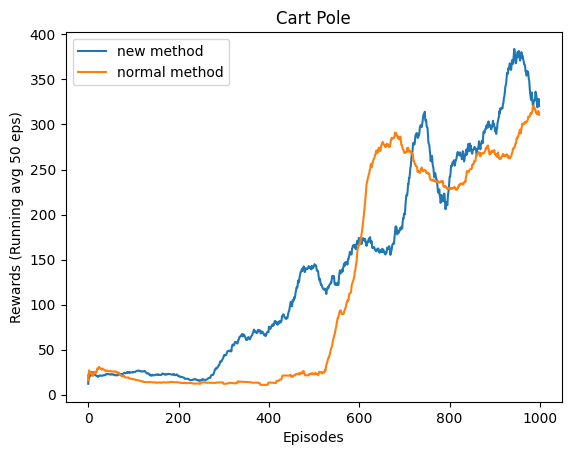

In [69]:
running_avg_len = 50
plt.title("Cart Pole")
plt.xlabel("Episodes")
plt.ylabel(f"Rewards (Running avg {running_avg_len} eps)")
plt.plot([np.mean(agent_cartpole_new.rewards[max(0,i-running_avg_len):i]) for i in np.arange(1,len(agent_cartpole_new.rewards))],label="new method")
plt.plot([np.mean(agent_cartpole.rewards[max(0,i-running_avg_len):i]) for i in np.arange(1,len(agent_cartpole.rewards))], label = "normal method")
plt.legend()
plt.show()

### Render Video of Normal method Deep Q Learning on Cart Pole env

In [70]:
env1 = wrap_env(gym.make("CartPole-v1",render_mode='rgb_array'))
env_render(env1,agent_cartpole)
env.close()
show_video()

Reward = 269.0


In [71]:
render_scores_cartpole = [run_episode(gym.make("CartPole-v1",render_mode=None),agent_cartpole) for i in range(50)]
print(f"Average render score of final policy of normal method on cartpole env is: {np.mean(render_scores_cartpole):.2f}")

Average render score of final policy of normal method on cartpole env is: 322.94


### Render Video of New method Deep Q Learning on Cart Pole env

In [72]:
env1 = wrap_env(gym.make("CartPole-v1",render_mode='rgb_array'))
env_render(env1,agent_cartpole_new)
env.close()
show_video()

Reward = 500.0


In [73]:
render_scores_cartpole = [run_episode(gym.make("CartPole-v1",render_mode=None),agent_cartpole_new) for i in range(50)]
print(f"Average render score of final policy of new method on cartpole env is: {np.mean(render_scores_cartpole):.2f}")

Average render score of final policy of new method on cartpole env is: 500.00
